# GDSII import

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/GDS.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/GDS.ipynb), or just follow along with the output below.

<img src="img/splitter.png" alt="diagram" width="400"/>

In Tidy3D, complex structures can be imported from GDSII files via the third-party [gdspy](https://gdspy.readthedocs.io/en/stable/index.html) package. In this tutorial, we will illustrate how GDS-defined structures can be imported in a Simulation. But before that, we will also illustrate how we can use `gdspy` to define a device that is ubiquitous in integrated photonics - a beam splitter based on a waveguide directional coupler.

In [1]:
# basic ipython configuration (reload source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import gdspy

# get the most recent version of tidy3d
!pip install -q --upgrade tidy3d

# tidy3D import
import tidy3d as td
from tidy3d import web

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Defining a beam splitter

We wish to construct an integrated beam splitter as in the title image in this notebook. We first define some structural parameters. The two arms of the device start at a distance `wg_spacing_in` apart, then come together at a coupling distance `wg_spacing_coup` for a certain length `coup_length`, and then split again into separate ports. In the coupling region, the field overlap results in energy exchange between the two waveguides. Here, we will only see how to define, import, and export such a device using `gdspy`, while in a later example we will simulate the device and study the frequency dependence of the transmission into each of the ports.

In [2]:
### Length scale in micron.

# Waveguide width
wg_width = 0.45
# Waveguide separation in the beginning/end
wg_spacing_in = 16
# Length of the coupling region
coup_length = 6
# Length of the bend region
bend_length = 16
# Waveguide separation in the coupling region
wg_spacing_coup = 0.10
# Total device length along propagation direction
device_length = 50

To create the device, we will define the waveguides as a GDSII path object with the given waveguide width. To do that, we just need to define a series of points along the center of each waveguide that follows the curvature we desire. First, we define a convenience function to create the central points along one of the waveguides, using a hyperbolic tangent curvature between the input and coupling regions. The second waveguide is just a reflected version of the first one.

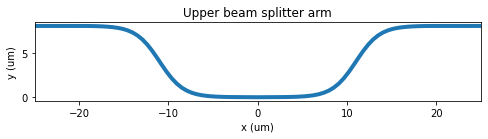

In [3]:
def bend_pts(bend_length, width, npts=10):
    """ Set of points describing a tanh bend from (0, 0) to (length, width)"""
    x = np.linspace(0, bend_length, npts)
    y = width*(1 + np.tanh(6*(x/bend_length - 0.5)))/2
    return np.stack((x, y), axis=1)

def arm_pts(length, width, coup_length, bend_length, npts_bend=30):
    """ Set of points defining one arm of an integrated coupler """
    ### Make the right half of the coupler arm first
    # Make bend and offset by coup_length/2
    bend = bend_pts(bend_length, width, npts_bend)
    bend[:, 0] += coup_length / 2
    # Add starting point as (0, 0)
    right_half = np.concatenate(([[0, 0]], bend))
    # Add end point as (length, width)
    right_half = np.concatenate((right_half, [[length, width]]))

    ### Make the left half by reflecting and omitting the (0, 0) point
    left_half = np.copy(right_half)[1:, :]
    left_half[:, 0] = -left_half[::-1, 0]
    left_half[:, 1] = left_half[::-1, 1]
    
    return np.concatenate((left_half, right_half), axis=0)

# Plot the upper arm for the current configuration
arm_center_coords = arm_pts(
    device_length,
    wg_spacing_in/2,
    coup_length,
    bend_length)

fig, ax = plt.subplots(1, figsize=(8, 3))
ax.plot(arm_center_coords[:, 0], arm_center_coords[:, 1], lw=4)
ax.set_xlim([-device_length/2, device_length/2])
ax.set_xlabel("x (um)")
ax.set_ylabel("y (um)")
ax.set_title("Upper beam splitter arm")
ax.axes.set_aspect('equal')
plt.show()

Next, we construct the splitter and write it to a GDS cell. We add two paths, one for the upper and one for the lower splitter arms, and set the path width to be the waveguide width defined above.

In [4]:
# Reset the gdspy library.
# This could be useful if re-running the notebook without restarting the kernel.
gdspy.current_library = gdspy.GdsLibrary()
lib = gdspy.GdsLibrary()

# Geometry must be placed in GDS cells to import into Tidy3D
coup_cell = lib.new_cell('Coupler')

def make_coupler(
    length, 
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
    npts_bend=30):
    """ Make an integrated coupler using the gdspy FlexPath object. """
    # Compute one arm of the coupler
    arm_width = (wg_spacing_in - wg_width - wg_spacing_coup)/2
    arm = arm_pts(length, arm_width, coup_length, bend_length, npts_bend)
    # Reflect and offset bottom arm
    coup_bot = np.copy(arm)
    coup_bot[:, 1] = -coup_bot[::-1, 1] - wg_width/2 - wg_spacing_coup/2
    # Offset top arm
    coup_top = np.copy(arm)
    coup_top[:, 1] += wg_width/2 + wg_spacing_coup/2
    
    # Create waveguides as GDS paths
    path_bot = gdspy.FlexPath(coup_bot, wg_width)
    path_top = gdspy.FlexPath(coup_top, wg_width)
    
    return [path_bot, path_top]

# Add the coupler to a gdspy cell
gds_coup = make_coupler(
    device_length,
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length)

coup_cell.add(gds_coup);

# Uncomment to display the cell using the internal gdspy viewer
# gdspy.LayoutViewer(lib)

We can now add this device to a Tidy3D simulation and see what we have created. We will not do a full run here, so we will not add sources and monitors - for now we will just illustrate how to add the structure. We make a silicon waveguide on an oxide substrate, and we also define a height of 220nm for the waveguide.

In [5]:
# Waveguide height
wg_height = 0.22

# Permittivity of waveguide and substrate
wg_eps = 3.48**2
sub_eps = 1.45**2
mat_wg = td.Medium(epsilon=wg_eps)
mat_sub = td.Medium(epsilon=sub_eps)

# Substrate
substrate = td.Box(
    center=[0, 0, -5],
    size=[td.inf, td.inf, 10],
    material=mat_sub)

# Waveguide
coupler = td.GdsSlab(
    coup_cell,
    z_cent=wg_height/2,
    z_size=wg_height,
    material=mat_wg)

# Simulation size along propagation direction
sim_length = 2*bend_length + coup_length
# Spacing between waveguides and PML
pml_spacing = 1
sim_size = [
    sim_length,
    wg_spacing_in + wg_width + 2*pml_spacing,
    wg_height + 2*pml_spacing]

# Mesh step in all directions
mesh_step = 0.020

Initializing simulation...
Mesh step (micron): [2.00e-02, 2.00e-02, 2.00e-02].
Simulation domain in number of grid points: [1924, 946, 135].
Total number of grid points: 2.46e+08.
Total number of time steps: 0.


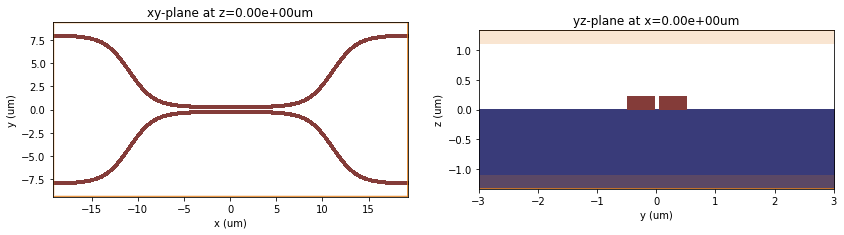

In [6]:
### Initialize and visualize simulation ###
sim = td.Simulation(
    size=sim_size,
    mesh_step=mesh_step, 
    structures=[substrate, coupler],
    pml_layers=[12, 12, 12])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sim.viz_mat_2D(normal='z', ax=ax1, source_alpha=1, monitor_alpha=1);
sim.viz_mat_2D(normal='x', ax=ax2, source_alpha=1, monitor_alpha=1);
ax2.set_xlim([-3, 3])
plt.show()

Finally, we will also save the GDS file for future use in one of our tutorials. There, we will see how to import structures from an existing file, and we will analyze the frequency-dependent properties of the integrated beam splitter.

In [7]:
lib.write_gds('data/coupler.gds')